In [3]:
#import libraries
import pickle
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfTransformer

#visualisation
import seaborn as sns
from matplotlib import pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Team: "Dmitry Dmitry"

> **Team-members:**

* Dmitry Rudoy
* Oleg Toygildin
* Dmitry Novoselov

# Data Loading

In [4]:
data_path = 'data/'

In [5]:
train_df = pd.read_csv(os.path.join(data_path, 'train.tsv.gz'), sep='\t', index_col='product_id')
test_df = pd.read_csv(os.path.join(data_path, 'test_nolabel.tsv.gz'), sep='\t', index_col='product_id')

y_train = train_df['sold_fast']
train_df.drop(['sold_fast'], axis=1, inplace=True)

In [6]:
train_df.head()

,Unnamed: 0,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_type,properties,region,sold_mode,subcategory_id
product_id,,,,,,,,,,,,,,,,,,
8cb80c05c65c210275f5500779d6b593,1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410
3b7a9f8b27a53b63525f95bc8070abb2,2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405
c97dd9c5a3e938c52cf5d7822bc0eb7b,4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908
3e5d0286b25fd7f62f88bc436a59ae4e,6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312
57b4a8679d0d3eb1e31367b57221098f,10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,1,[],Московская область,1,504


In [9]:
train_df.columns

Index(['Unnamed: 0', 'category_id', 'city', 'date_created',
       'delivery_available', 'desc_text', 'img_num', 'lat', 'long',
       'name_text', 'owner_id', 'payment_available', 'price', 'product_type',
       'properties', 'region', 'sold_mode', 'subcategory_id'],
      dtype='object')

In [10]:
train_df.shape, test_df.shape, y_train.shape

((351281, 18), (89251, 18), (351281,))

It will better to change type of day_created feature to analyse in "Descriptive Data Analysis".

In [0]:
train_df['date_created'] = train_df['date_created'].apply(pd.to_datetime)
test_df['date_created'] = test_df['date_created'].apply(pd.to_datetime)

In [0]:
train_df['year_created'] = train_df['date_created'].apply(lambda x: x.year)
train_df['month_created'] = train_df['date_created'].apply(lambda x: x.month)
train_df['day_created'] = train_df['date_created'].apply(lambda x: x.day)
train_df['wd_created'] = train_df['date_created'].apply(pd.datetime.weekday)

test_df['year_created'] = test_df['date_created'].apply(lambda x: x.year)
test_df['month_created'] = test_df['date_created'].apply(lambda x: x.month)
test_df['day_created'] = test_df['date_created'].apply(lambda x: x.day)
test_df['wd_created'] = test_df['date_created'].apply(pd.datetime.weekday)

# Descriptive Data Analysis

##Price

Let's look at the price columns.

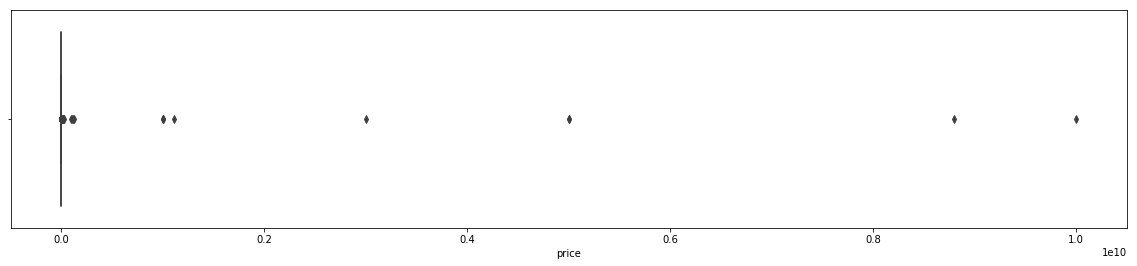

In [0]:
plt.figure(figsize=(20,4))
sns.boxplot(x = train_df['price'])

We can see that there are outliers. So we should remove them. Let's take 0.005 of maximum.

In [0]:
1 - train_df[train_df['price'] < train_df['price'].max()*0.005].shape[0] / train_df.shape[0]

3.700741002221619e-05

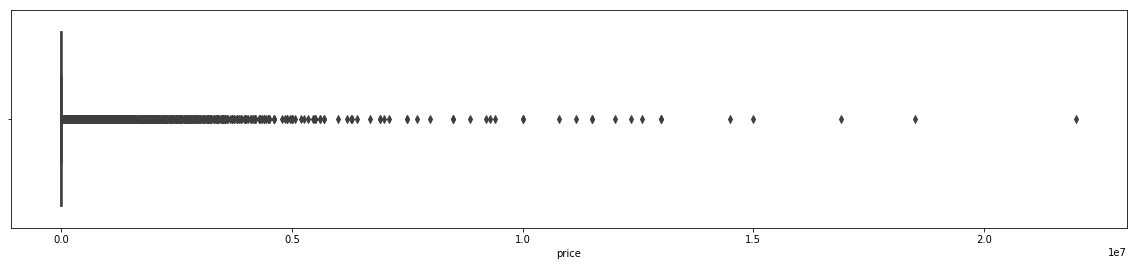

In [0]:
plt.figure(figsize=(20,4))
sns.boxplot(x = train_df[train_df['price'] < train_df['price'].max()*0.005]['price'])

Looks better!

## Category and Subcategory IDs

Let's look if there is a differense in category_id destribution

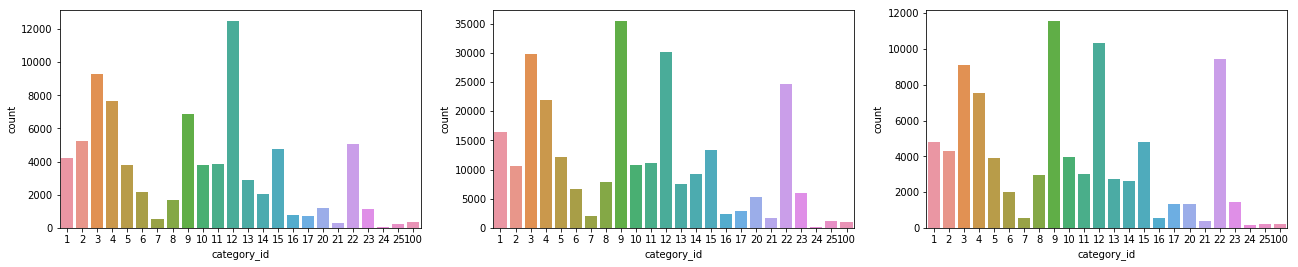

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x='category_id', data=train_df[y_train == 1], ax=axes[0]);
sns.countplot(x='category_id', data=train_df[y_train == 0], ax=axes[1])
sns.countplot(x='category_id', data=test_df, ax=axes[2]);

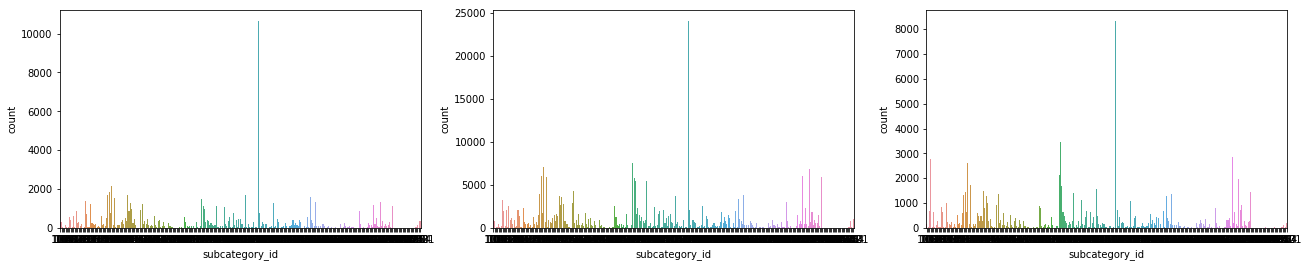

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x='subcategory_id', data=train_df[y_train == 1], ax=axes[0]);
sns.countplot(x='subcategory_id', data=train_df[y_train == 0], ax=axes[1])
sns.countplot(x='subcategory_id', data=test_df, ax=axes[2]);

We definitely see the difference. Let's take a closer look.

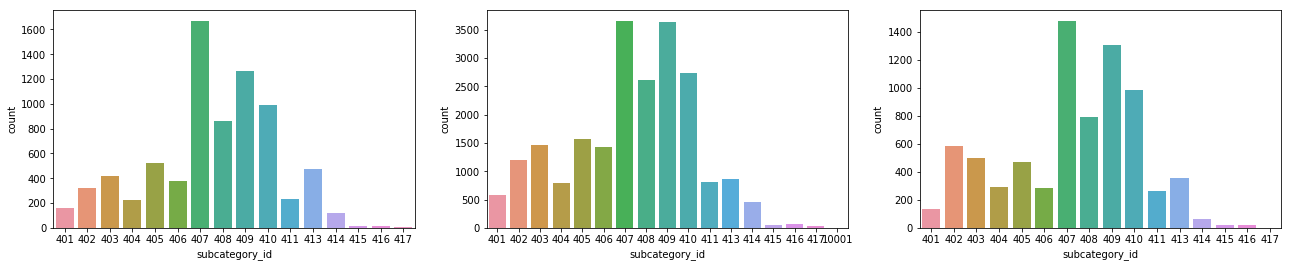

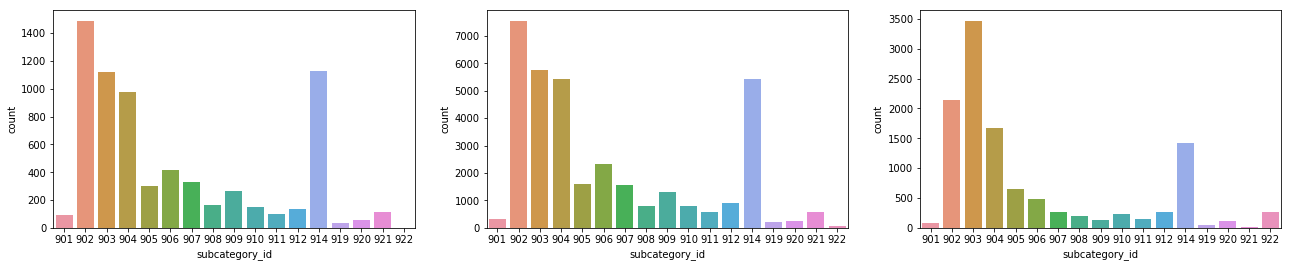

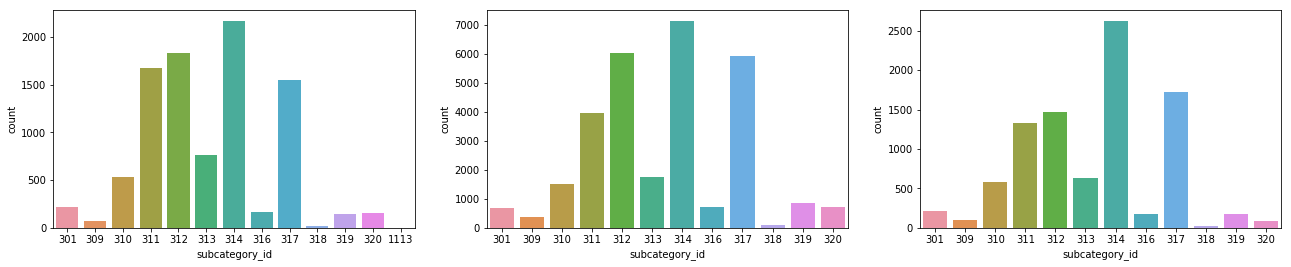

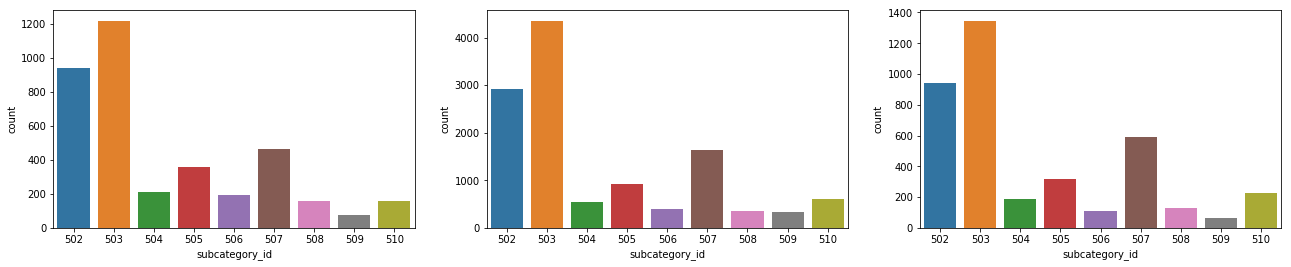

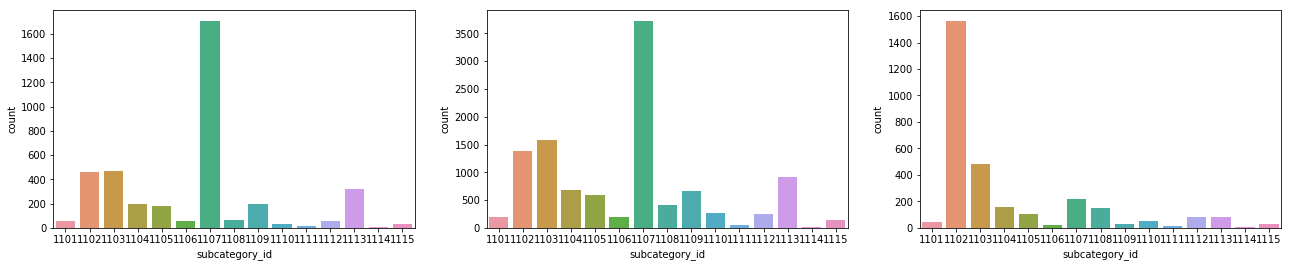

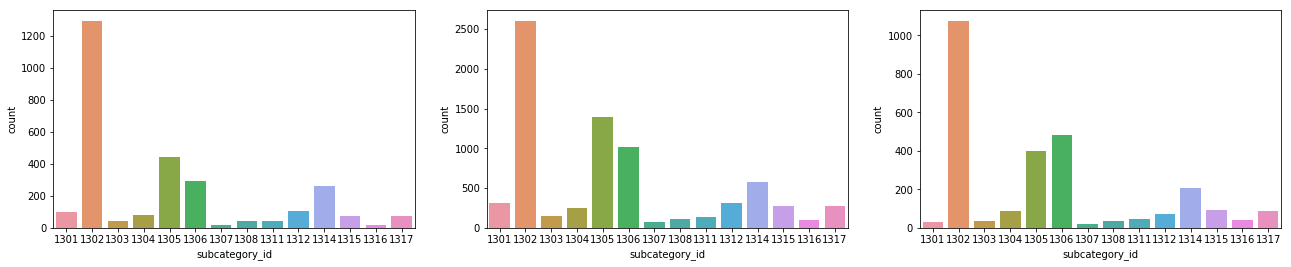

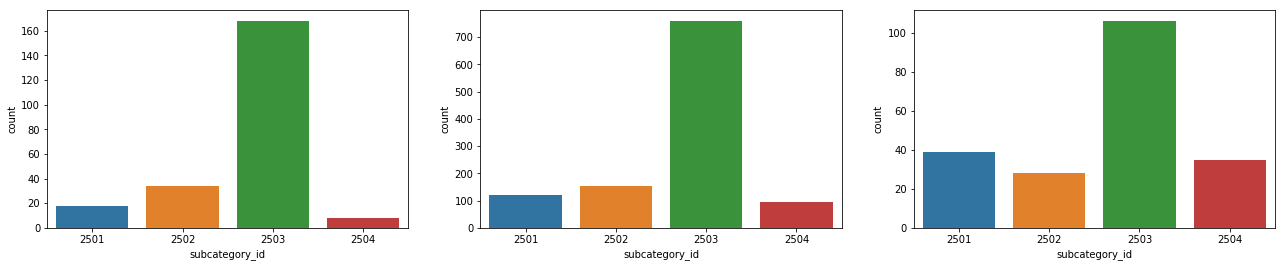

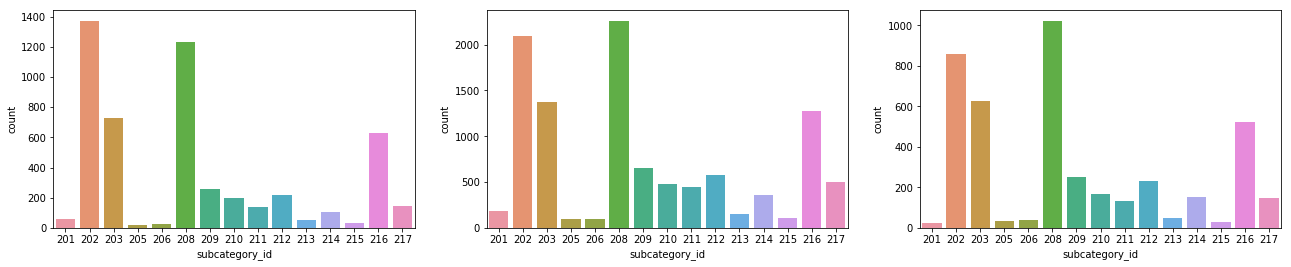

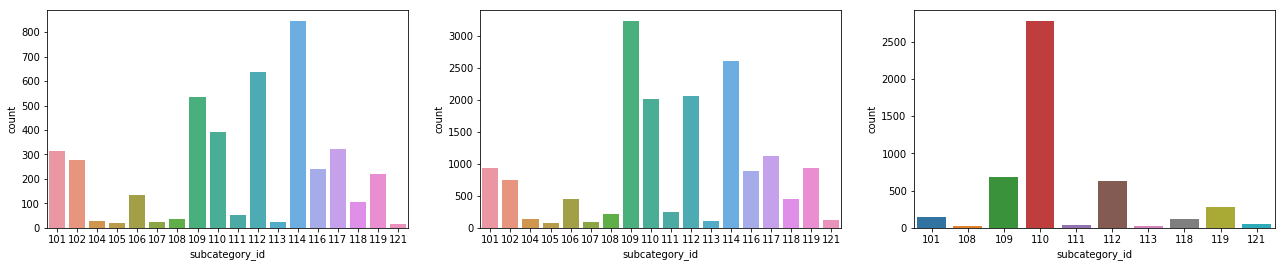

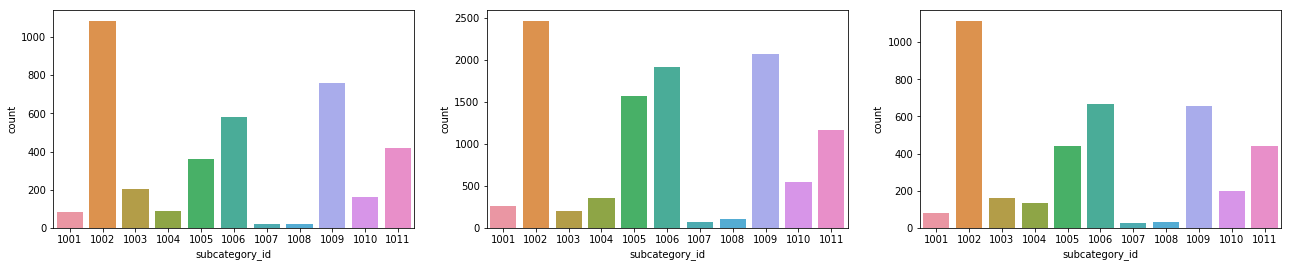

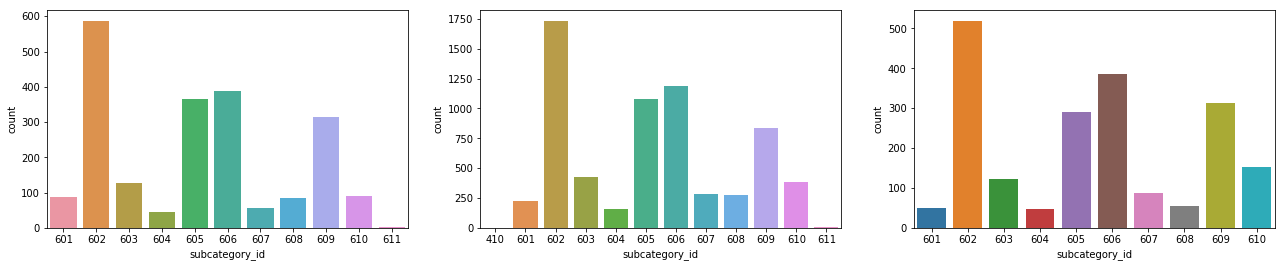

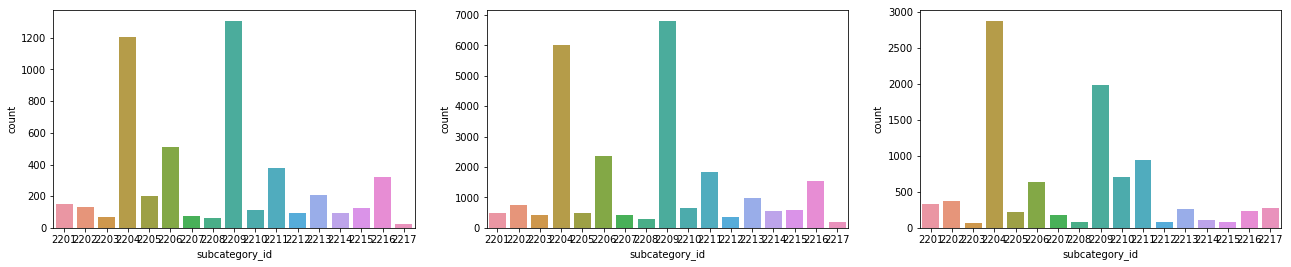

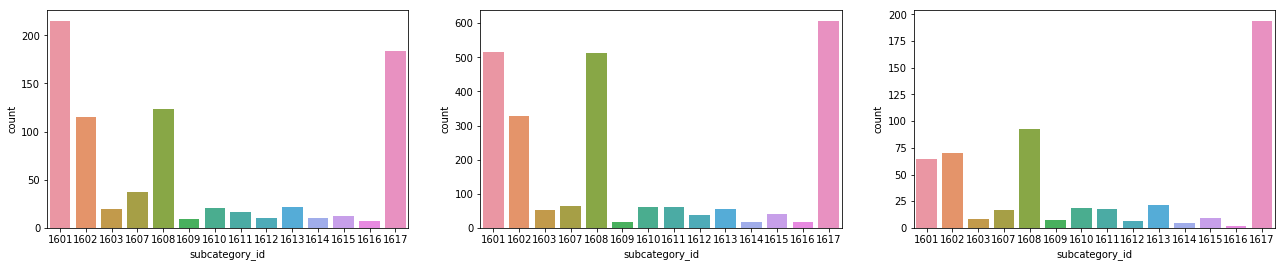

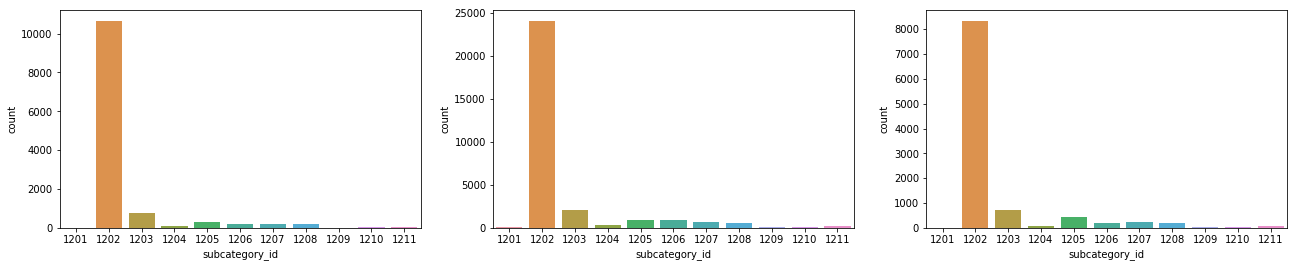

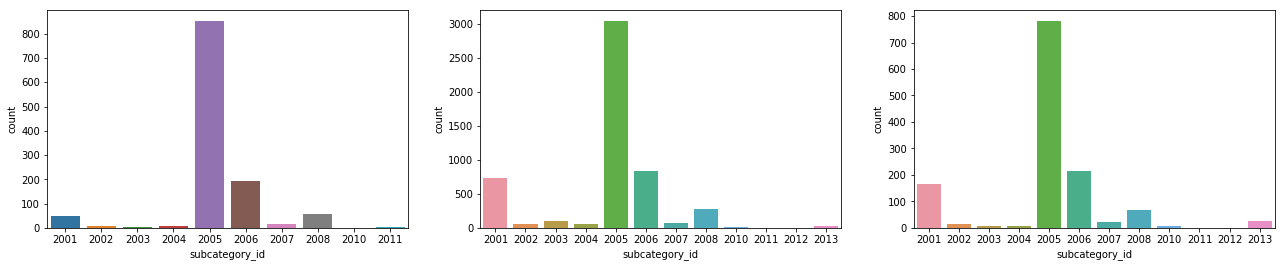

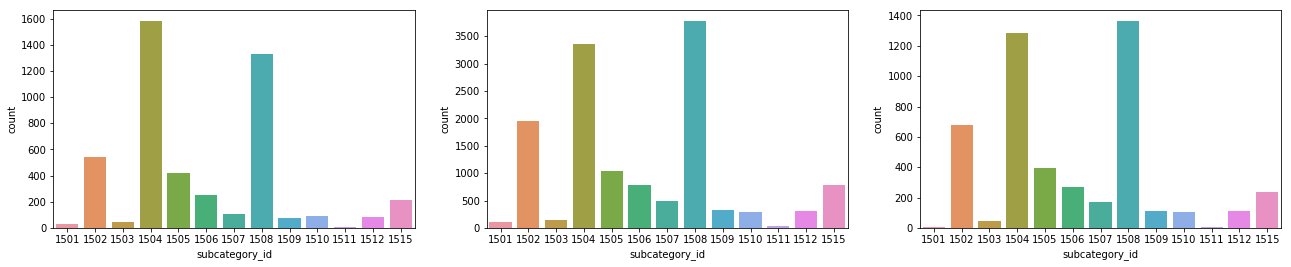

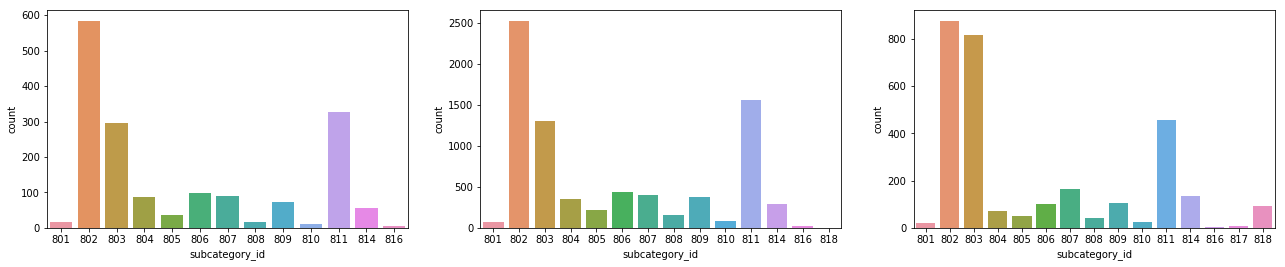

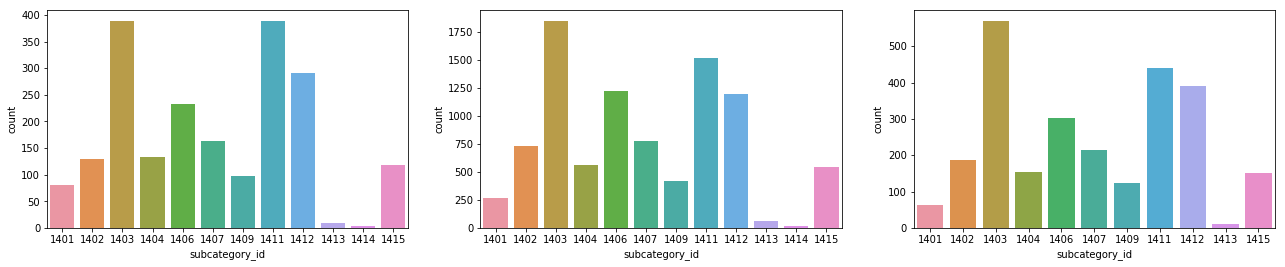

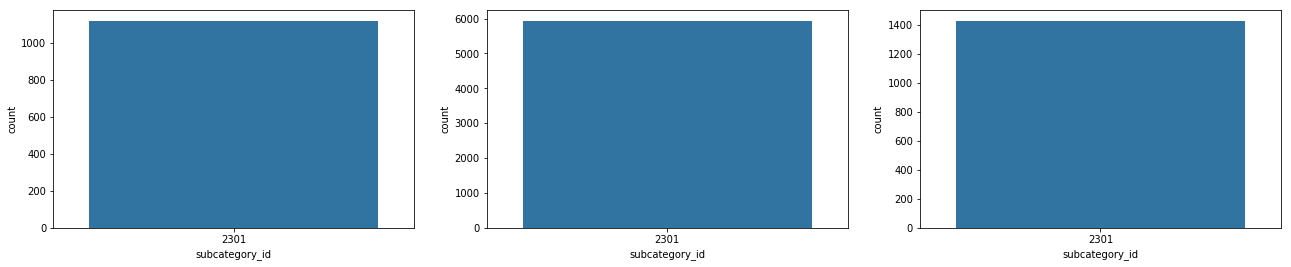

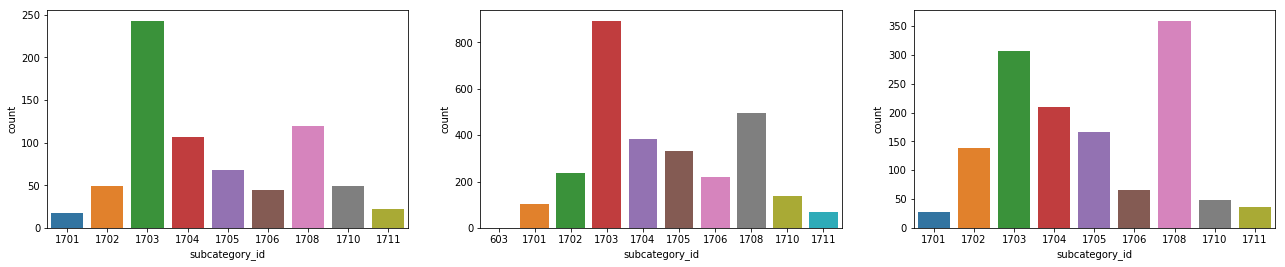

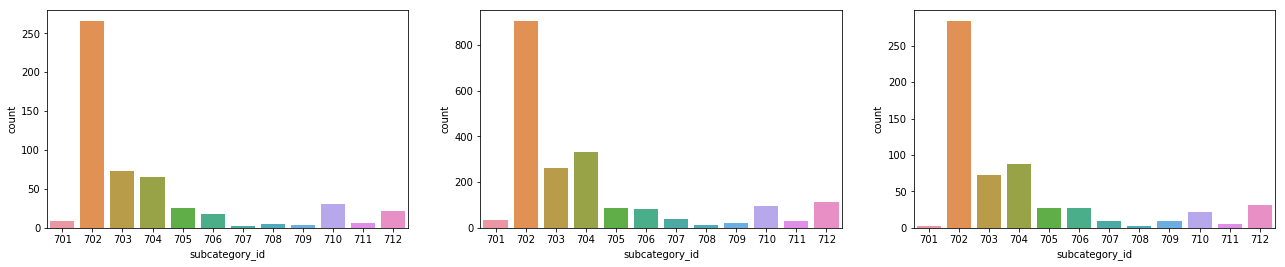

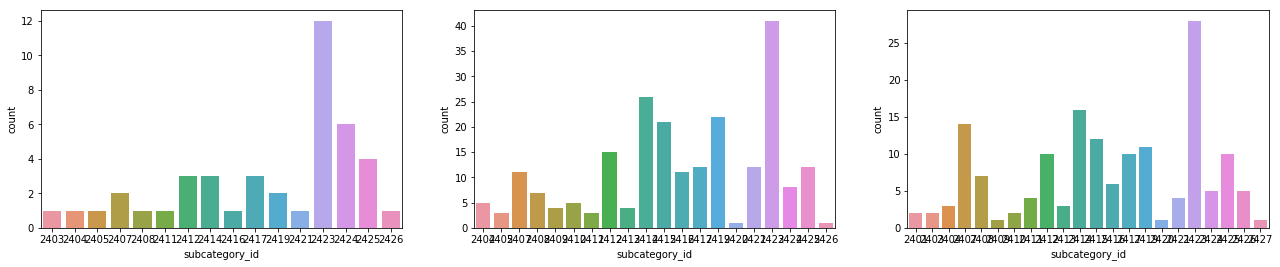

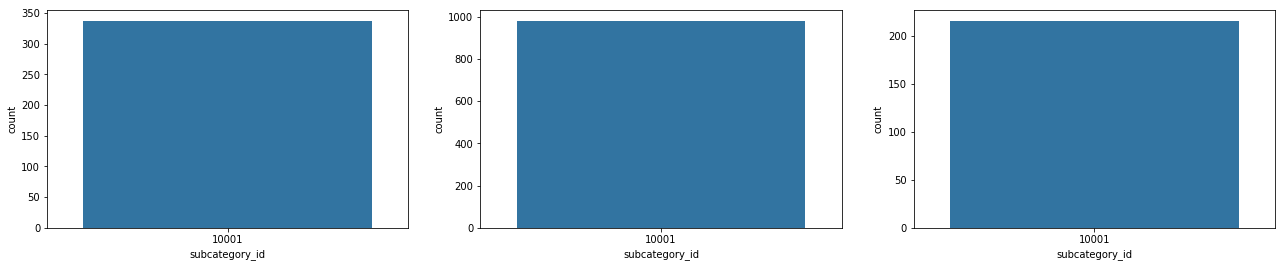

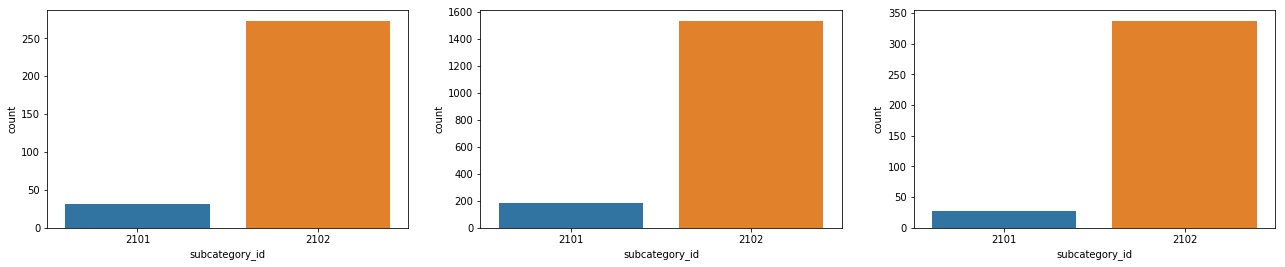

In [0]:
for i in train_df['category_id'].unique():
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
    sns.countplot(x='subcategory_id', data=train_df[train_df['category_id'] == i][y_train == 1], ax=axes[0]);
    sns.countplot(x='subcategory_id', data=train_df[train_df['category_id'] == i][y_train == 0], ax=axes[1])
    sns.countplot(x='subcategory_id', data=test_df[test_df['category_id'] == i], ax=axes[2]);

Let's look on difference in prices between categories.

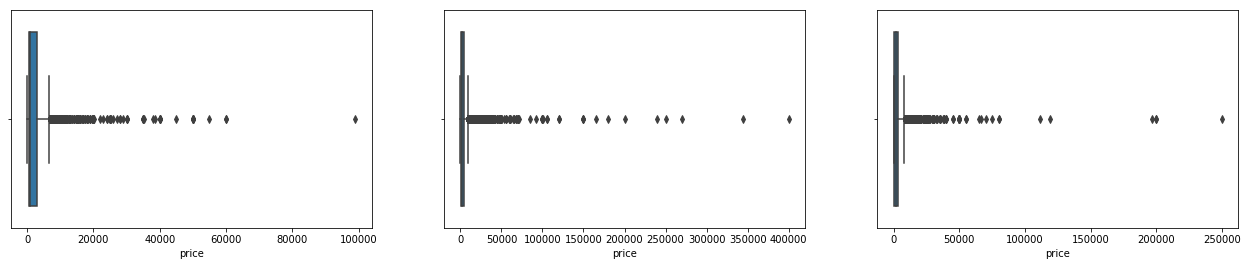

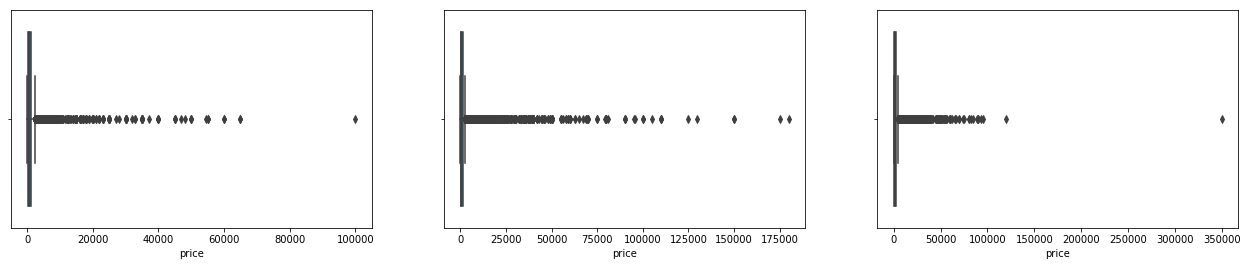

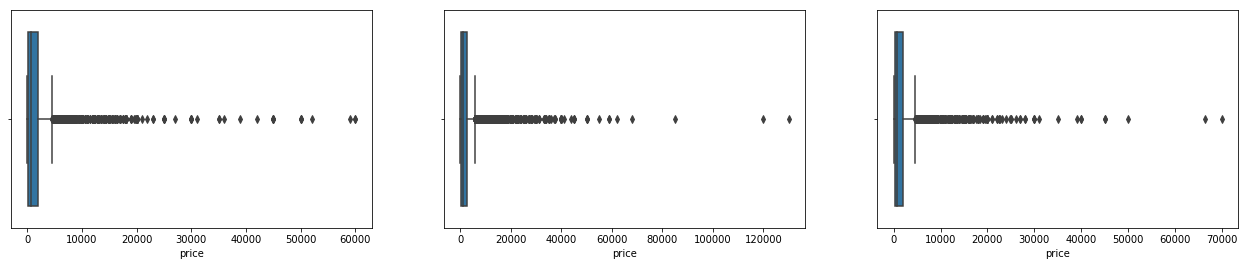

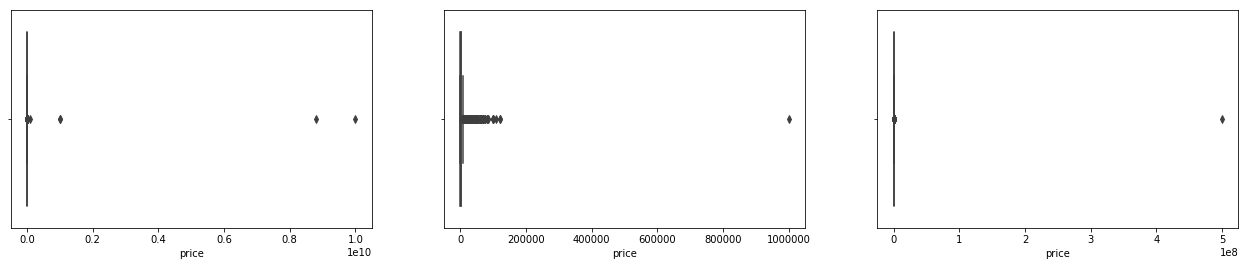

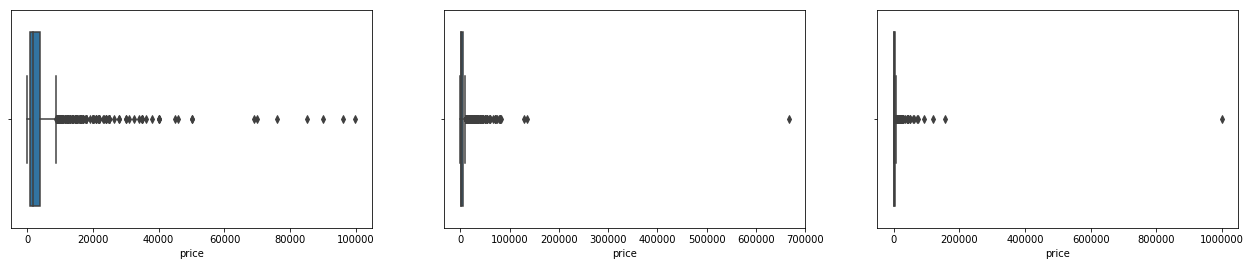

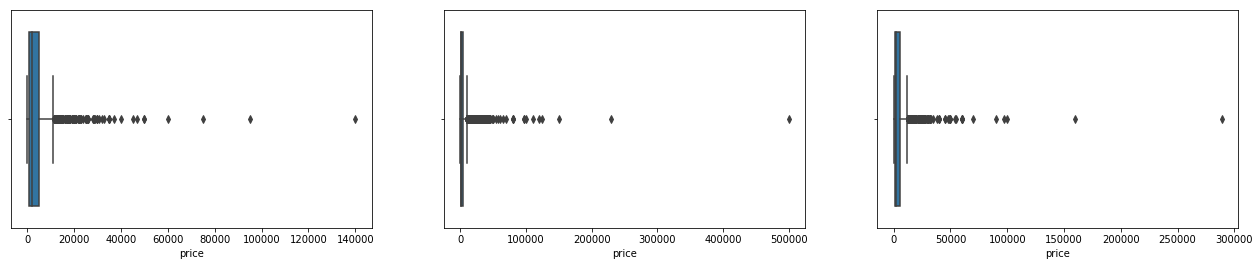

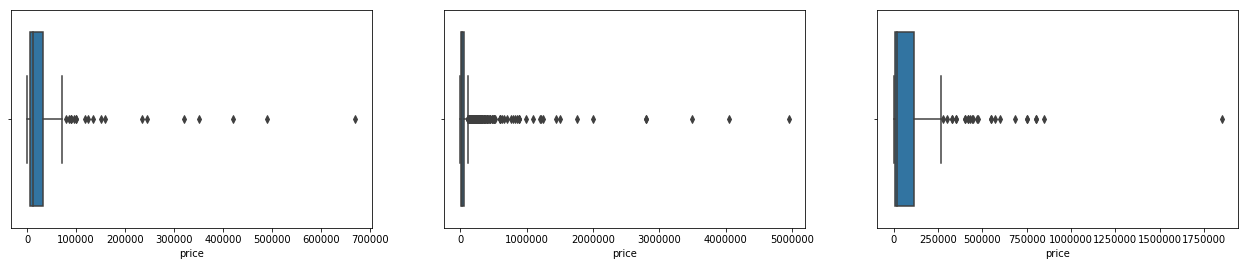

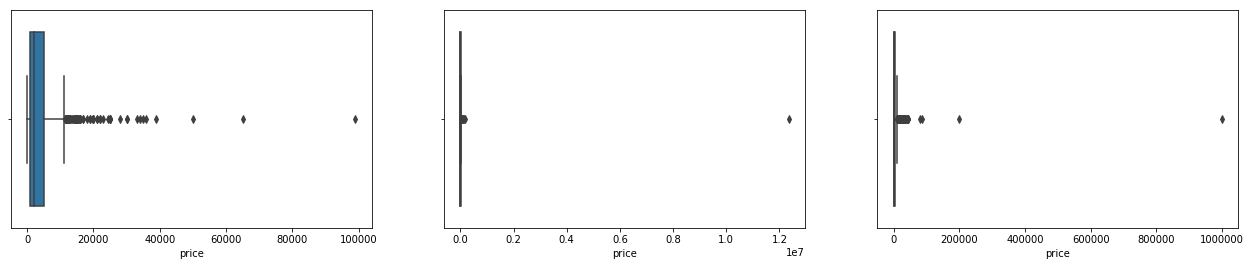

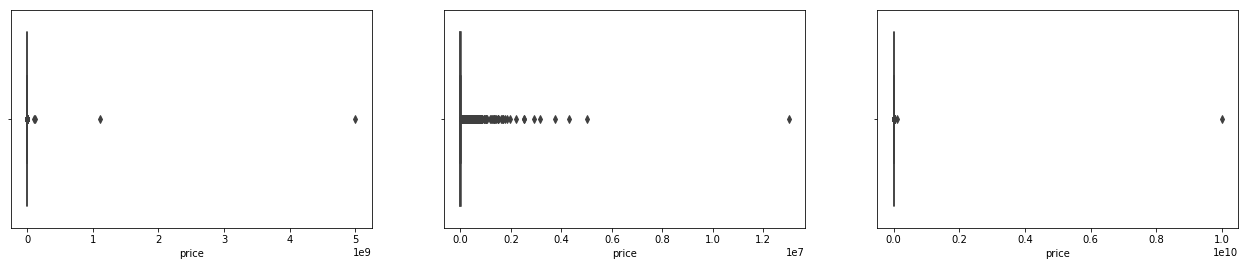

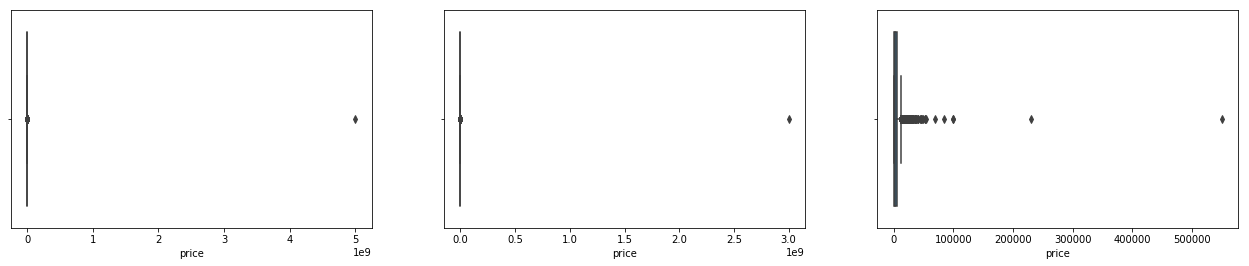

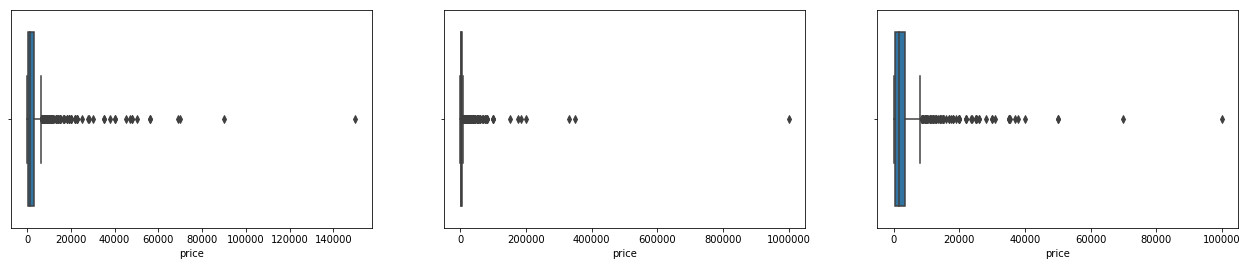

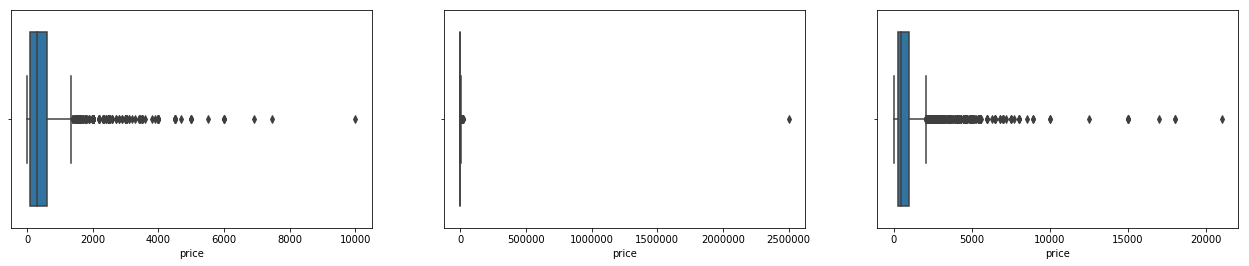

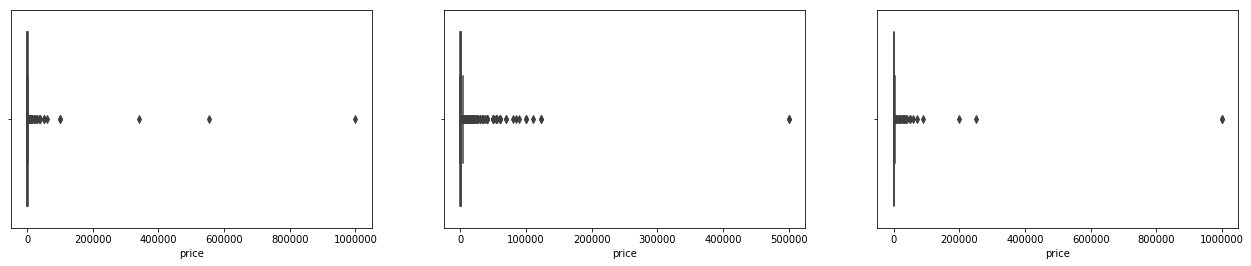

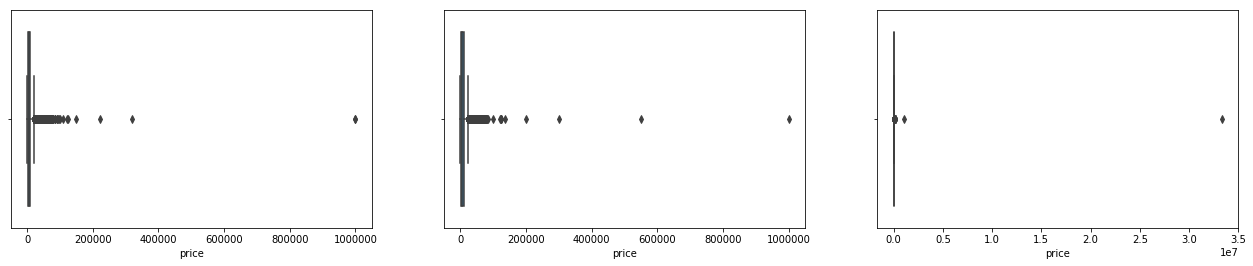

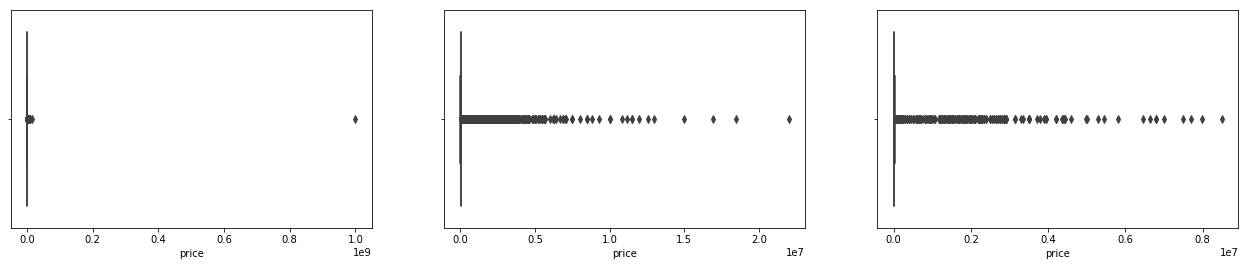

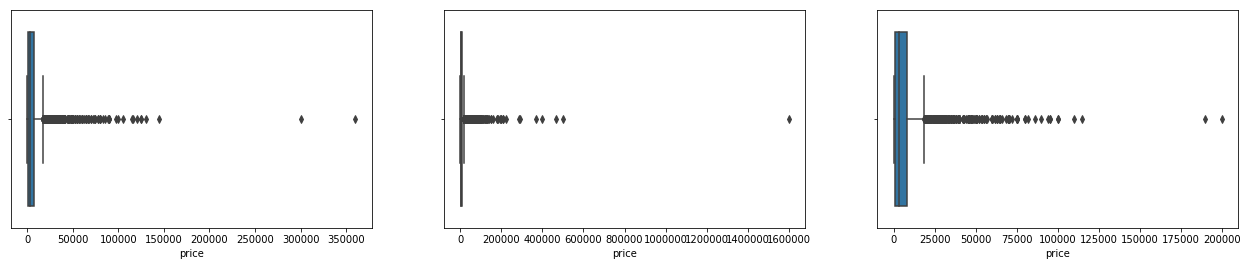

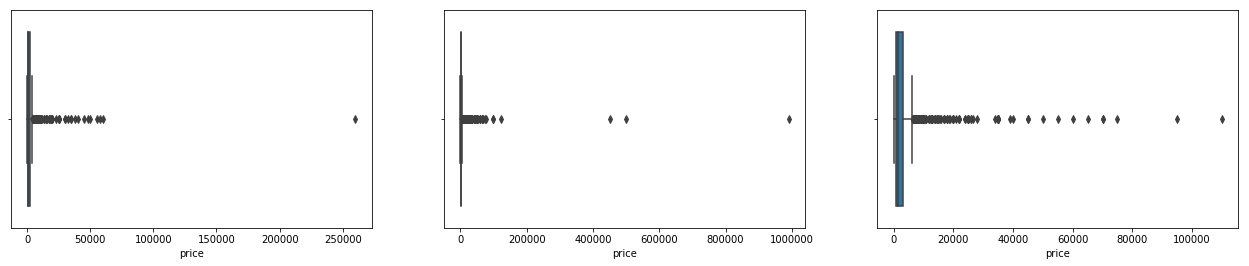

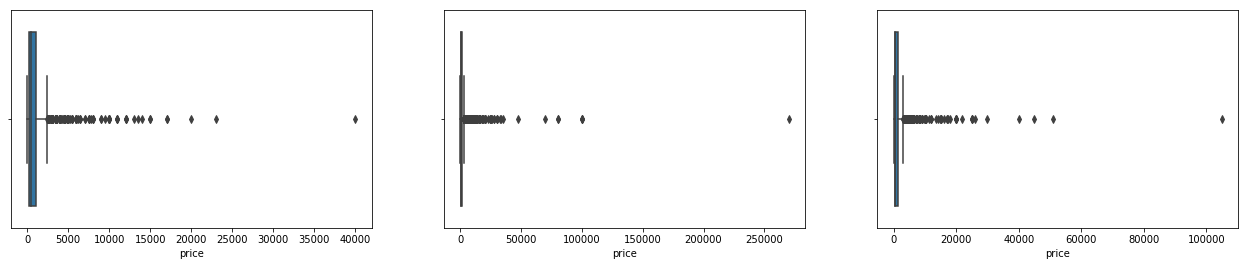

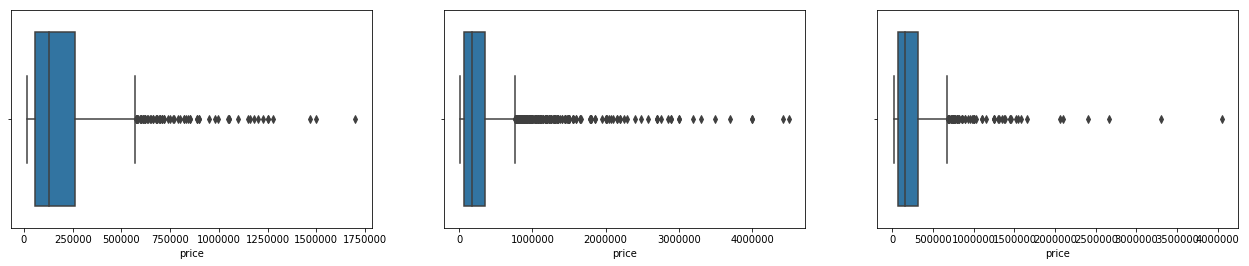

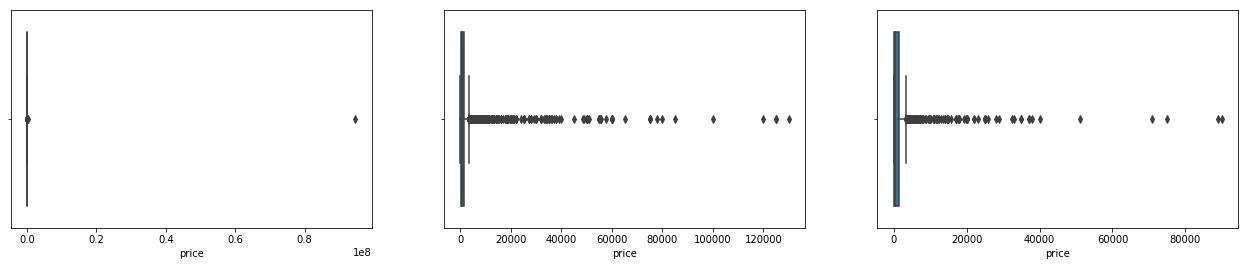

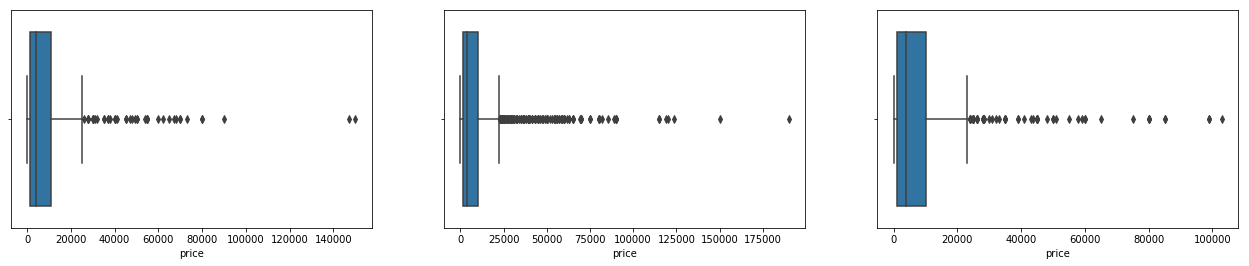

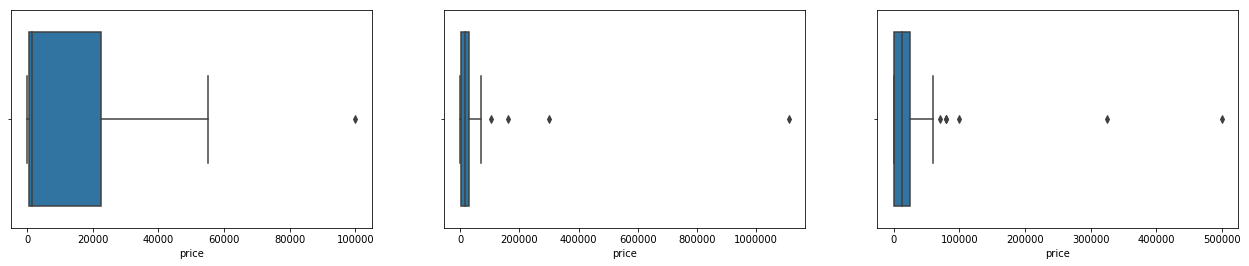

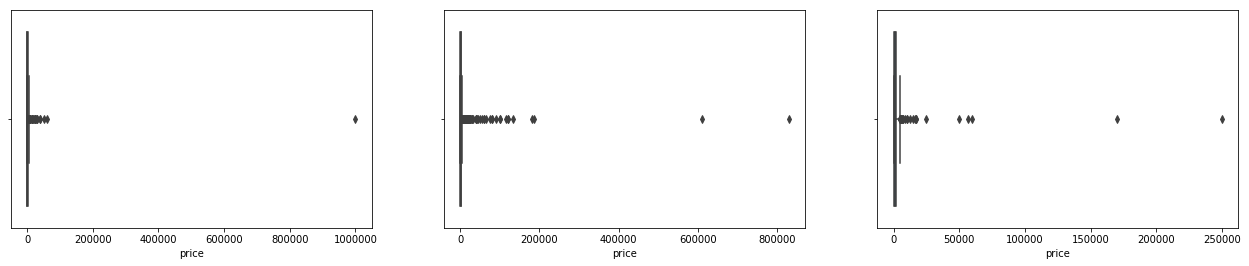

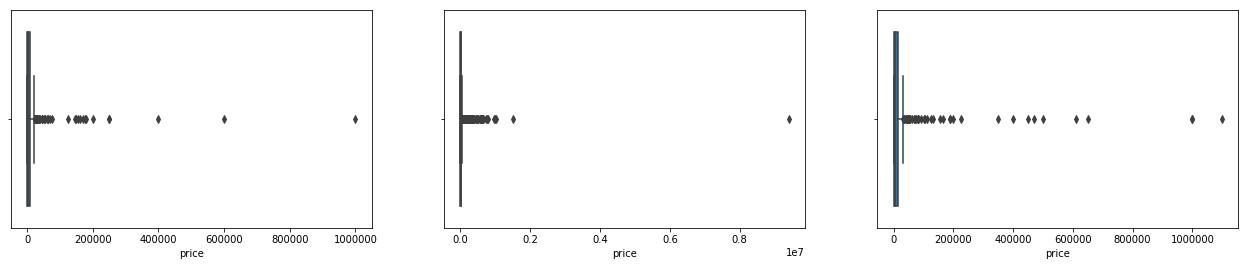

In [0]:
for i in train_df['category_id'].unique():
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
    sns.boxplot(x=train_df[train_df['category_id'] == i][y_train == 1]['price'], ax=axes[0])
    sns.boxplot(x=train_df[train_df['category_id'] == i][y_train == 0]['price'], ax=axes[1])
    sns.boxplot(x=test_df[test_df['category_id'] == i]['price'], ax=axes[2])

We can see that practically everywhere there is a significant difference between sold items and not.

## Lat / Long

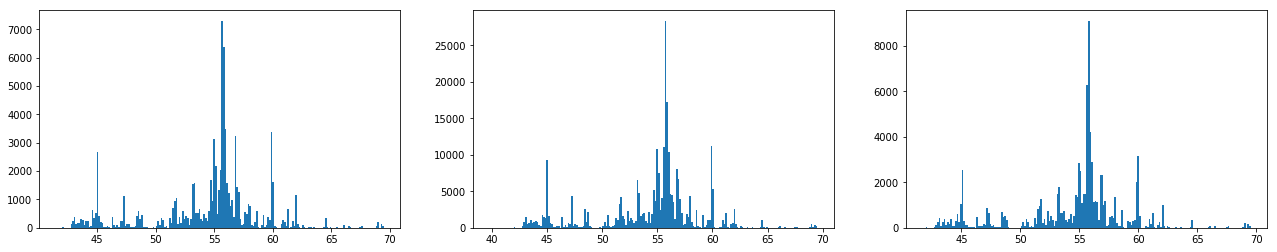

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
axes[0].hist(train_df[y_train == 1]['lat'].values, bins = 200);
axes[1].hist(train_df[y_train == 0]['lat'].values, bins = 200);
axes[2].hist(test_df['lat'].values, bins = 200);

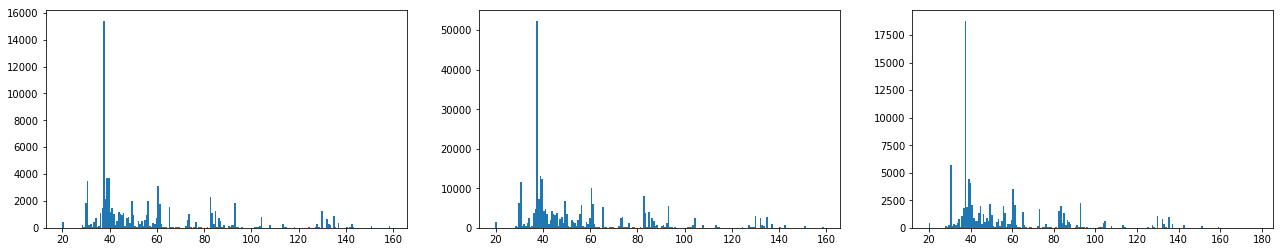

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
axes[0].hist(train_df[y_train == 1]['long'].values, bins = 200);
axes[1].hist(train_df[y_train == 0]['long'].values, bins = 200);
axes[2].hist(test_df['long'].values, bins = 200);

We can see almost the same destribution.

## Date created

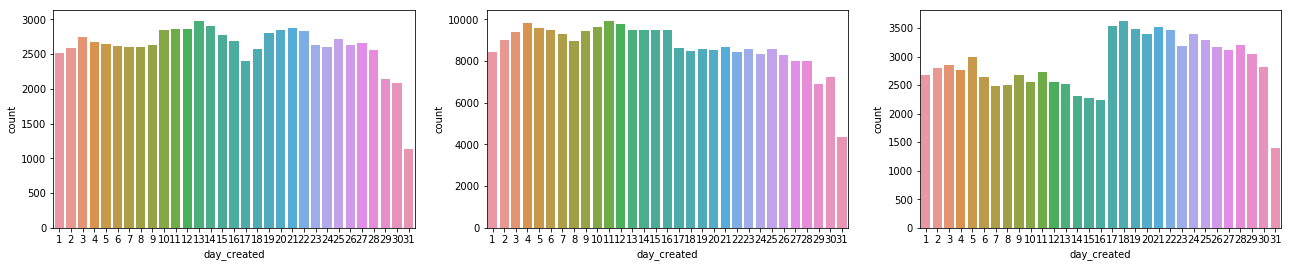

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x='day_created', data=train_df[y_train == 1], ax=axes[0]);
sns.countplot(x='day_created', data=train_df[y_train == 0], ax=axes[1])
sns.countplot(x='day_created', data=test_df, ax=axes[2]);

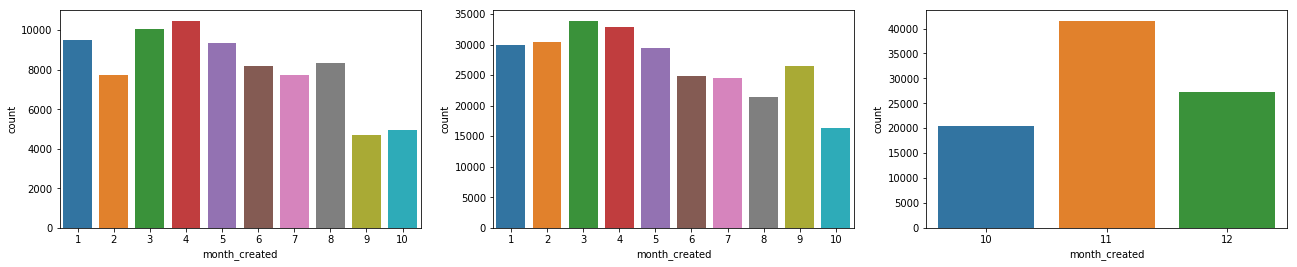

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x='month_created', data=train_df[y_train == 1], ax=axes[0]);
sns.countplot(x='month_created', data=train_df[y_train == 0], ax=axes[1])
sns.countplot(x='month_created', data=test_df, ax=axes[2]);

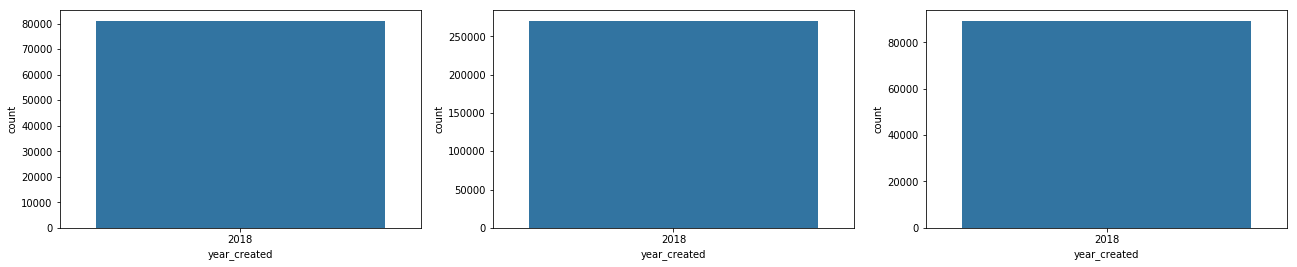

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x='year_created', data=train_df[y_train == 1], ax=axes[0]);
sns.countplot(x='year_created', data=train_df[y_train == 0], ax=axes[1])
sns.countplot(x='year_created', data=test_df, ax=axes[2]);

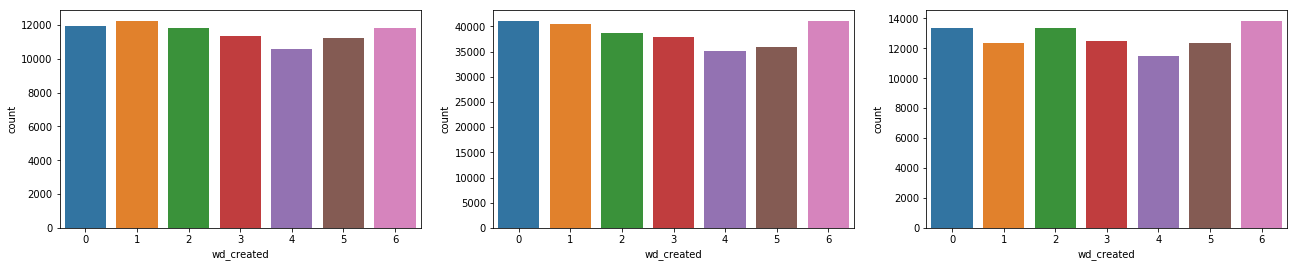

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x='wd_created', data=train_df[y_train == 1], ax=axes[0]);
sns.countplot(x='wd_created', data=train_df[y_train == 0], ax=axes[1])
sns.countplot(x='wd_created', data=test_df, ax=axes[2]);

1. There is slight difference in 'day_created' destribution.
2. There are absolutely different values in 'month_created'.
3. There is no need in 'year_created' feature because there is only one value there.
4. Only slight difference in 'wd_created'

## Other

Let's discover 'Unnamed: 0' meaning.

In [0]:
len(train_df['Unnamed: 0'].unique()) / train_df.shape[0]

1.0

We can say that 'Unnamed: 0' has unique value for every row. So we can remove it.

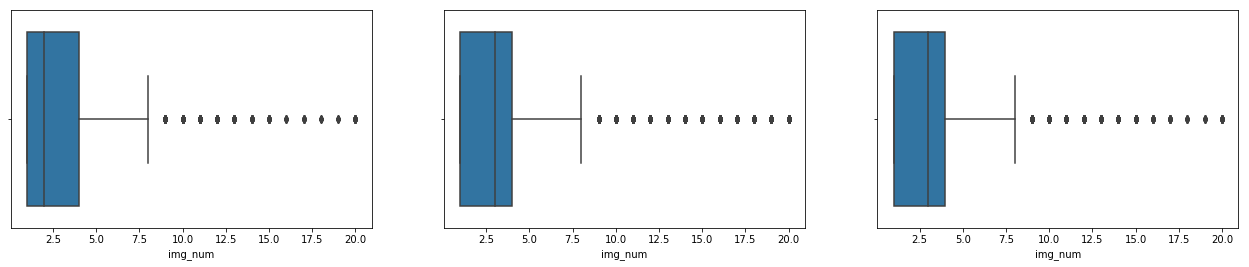

In [0]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.boxplot(x=train_df[y_train == 1]['img_num'], ax=axes[0])
sns.boxplot(x=train_df[y_train == 0]['img_num'], ax=axes[1])
sns.boxplot(x=test_df['img_num'], ax=axes[2])

Destribution is almost the same.

Let's check if there is wrong numbers in numerical data

In [0]:
print(train_df[train_df['price'] < 0].shape)
print(train_df[train_df['img_num'] < 0].shape)

(0, 22)
(0, 22)


# Machine-learning pipeline and prediction

## Preprocessing

In [0]:
# Firstly, let's remove outliers

target = y_train[train_df['price'] < train_df['price'].max() * 0.005]
train_df = train_df[train_df['price'] < train_df['price'].max() * 0.005]

In [0]:
# Concatenate train_df and test_df.

train_test_df = pd.concat([train_df, test_df])

In [0]:
# Change boolean features to 1/0 int

train_test_df['delivery_available'] = train_test_df['delivery_available'].apply(int)
train_test_df['payment_available'] = train_test_df['payment_available'].apply(int)

In [0]:
# Let's create feature of how many times in dataset one owner are selling items.

owner_counts_train = train_test_df['owner_id'].value_counts()
train_test_df['owner_count'] = train_test_df['owner_id'].apply(lambda x: owner_counts_train[x])

In [0]:
# How many words is in desc_text. Which desctibes size of the description.

train_test_df['desc_count'] = train_test_df['desc_text'].apply(lambda x: len(x.split()))

We desided to use more data. City population could be very usefull. Because it's the number of potential customers. 
We found the site with population of Russian citys with population more than 23869. So if the number is lower then we assign 23869 / 2 value.

In [0]:
city_df = pd.read_csv(os.path.join(data_path, city_population.csv), sep=';', index_col='city')
city_df['population'] = city_df['population'].apply(lambda x: int(x.replace('\xa0', '')))
city_df = city_df.loc[~city_df.index.duplicated(keep='first')]

def get_city_population(line):
    if line in city_df.index:
        return city_df['population'].loc[line]
    else:
        # print(f'Not Found: {line}')
        return 23869 / 2
      
train_test_df['city_population'] = train_test_df['city'].apply(get_city_population)   

In [0]:
from ast import literal_eval

# Let's find how many item properties was added.

train_test_df['properties_len'] = train_test_df['properties'].apply(lambda x: len(literal_eval(x)))

Let's create another feature based on prices of category for some categorial features.

* Price_ _def: (price - category_min) / category_max
* Price_ _mid_ratio: price / category_median

In [20]:
%%time

min_max_features = ['category_id', 'subcategory_id', 'month_created', 'day_created', 'city']

for feature in min_max_features:
    min_dict = {}
    max_dict = {}
    mid_dict = {}

    for i in train_test_df[feature].unique():
        feature_prices = train_test_df[train_test_df[feature] == i]['price']
        
        min_dict[i] = feature_prices.min()
        max_dict[i] = feature_prices.max()
        mid_dict[i] = feature_prices.median()

    train_test_df['price_' + feature + '_def'] = train_test_df.apply(lambda x: (x['price'] - min_dict[x[feature]]) / 
                                           max_dict[x[feature]], axis=1)
    
    train_test_df['price_' + feature + '_mid_ratio'] = train_test_df.apply(lambda x: (x['price'] + 0.01) / (mid_dict[x[feature]] + 0.01), axis=1)

CPU times: user 3min 14s, sys: 1.62 s, total: 3min 15s
Wall time: 3min 15s


I tried to use TfidfVectorizer or CountVectorizer for slug_ids and value_ids, but it gave only decline.

In [21]:
%%time

from ast import literal_eval

def get_slug_ids(line):
    property_line = literal_eval(line)
    slug_list = []
    for prop in property_line:
        slug_list.append(str(prop['slug_id']))
    return ' '.join(slug_list)
  
def get_value_ids(line):
    property_line = literal_eval(line)
    value_list = []
    for prop in property_line:
        value_list.append(str(prop['value_id']))
    return ' '.join(value_list)

train_test_df['slug_ids'] = train_test_df['properties'].apply(get_slug_ids)
train_test_df['value_ids'] = train_test_df['properties'].apply(get_value_ids)

CPU times: user 51.1 s, sys: 429 ms, total: 51.6 s
Wall time: 51.6 s


Calculating Z-score for categorys. But it gave only decline.

In [0]:
category_price_mean = {}
category_price_std = {}

for cat in train_test_df['category_id'].unique():
    category_price_mean[cat] = train_test_df[train_test_df['category_id'] == cat]['price'].mean()
    category_price_std[cat] = train_test_df[train_test_df['category_id'] == cat]['price'].std()
    
def get_z_cat(line):
    return (line['price'] - category_price_mean[line['category_id']]) / category_price_std[line['category_id']]

train_test_df['category_z'] = train_test_df.apply(get_z_cat, axis=1)

In [23]:
train_test_df.head()

,Unnamed: 0,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_type,properties,region,sold_mode,subcategory_id,year_created,month_created,day_created,wd_created,owner_count,desc_count,city_population,properties_len,price_category_id_def,price_category_id_mid_ratio,price_subcategory_id_def,price_subcategory_id_mid_ratio,price_month_created_def,price_month_created_mid_ratio,price_day_created_def,price_day_created_mid_ratio,price_city_def,price_city_mid_ratio,slug_ids,value_ids,category_z
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8cb80c05c65c210275f5500779d6b593,1,4,Краснодар,2018-10-08,0,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,1,500.0,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,2018,10,8,0,1,14,881476.0,1,0.001250,0.333338,0.002000,0.416672,0.000005,0.333338,0.000111,0.333338,0.000027,0.333338,stoly_stulya_tip,9490,-0.376161
3b7a9f8b27a53b63525f95bc8070abb2,2,4,Тюмень,2018-06-18,0,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,0,300.0,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,2018,6,18,0,1,27,744554.0,1,0.000750,0.200005,0.002985,0.750006,0.000016,0.214291,0.000067,0.200005,0.000072,0.200005,dom_dacha_posuda_tip,9461,-0.405113
c97dd9c5a3e938c52cf5d7822bc0eb7b,4,9,Омск,2018-07-31,1,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,1,1100.0,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,2018,7,31,1,1,22,1178391.0,2,0.003143,1.833319,0.008462,1.374995,0.000129,0.733335,0.000110,0.733335,0.000407,1.099999,zhenskaya_odezhda_pidzhaki_kostyumy_tip zhensk...,8362 8290,-0.126460
3e5d0286b25fd7f62f88bc436a59ae4e,6,3,Санкт-Петербург,2018-04-17,0,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,1,5000.0,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,2018,4,17,1,1,77,5281579.0,2,0.038462,5.813898,0.058824,1.428570,0.000333,4.068323,0.000296,3.355689,0.000735,3.846132,waggon_type waggon_max_age,8615 8620,0.816017
57b4a8679d0d3eb1e31367b57221098f,10,5,Москва,2018-02-09,0,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,1,2000.0,1,[],Московская область,1,504,2018,2,9,4,1,12,12500123.0,0,0.000004,3.999940,0.009091,2.499981,0.000138,1.333331,0.000154,1.538457,0.000091,1.333331,,,-0.007475


In [24]:
train_test_df.shape

(440519, 39)

In [0]:
train_test_df.to_pickle('X_train_test.pkl')

## Choosing best features

In [0]:
X_train_test = pd.read_pickle('X_train_test.pkl')

In [0]:
# Choose best features

chosen_cols = [
#   'Unnamed: 0',
    'category_id',
    'city',
#   'date_created',
    'delivery_available',
#   'desc_text',
    'img_num',
    'lat',
    'long',
#   'name_text',
#   'owner_id',
    'payment_available',
    'price',
    'product_type',
#   'properties',
#   'region',
    'sold_mode',
    'subcategory_id',
    'month_created',
    'wd_created',
    'day_created',
    'owner_count',
    'desc_count',
    'city_population',
    'properties_len',
    'price_category_id_def',
#   'price_category_id_mid_ratio',
#   'price_subcategory_id_def',
#   'price_subcategory_id_mid_ratio',
    'price_month_created_def',
#   'price_month_created_mid_ratio',
    'price_day_created_def',
#   'price_day_created_mid_ratio',
#   'price_city_def',
#   'price_city_mid_ratio',
#   'slug_ids',
#   'value_id' ,
#   'category_z',
]

So features that weren't chosen didn't give any improvement.

In [0]:
X_train_test = X_train_test[chosen_cols]

In [0]:
# Features that we will not transform with OHE

categorical_cols = [
    'city'
]

# Features that we will transform with OHE

dummy_cols = [
    'category_id',
    'product_type',
    'subcategory_id',
    'month_created',
    'wd_created',
    'day_created',
]

In [0]:
from sklearn.preprocessing import LabelEncoder

X_train_test = pd.get_dummies(X_train_test, columns=dummy_cols)

for col in categorical_cols:
    le = LabelEncoder()
    X_train_test[col] = le.fit_transform(X_train_test[col])

X_train = X_train_test[:train_df.shape[0]]
X_test = X_train_test[train_df.shape[0]:]

In [27]:
X_train.shape, X_test.shape, target.shape

((351268, 377), (89251, 377), (351268,))

In [28]:
X_train.head()

,city,delivery_available,img_num,lat,long,payment_available,price,sold_mode,owner_count,desc_count,city_population,properties_len,price_category_id_def,price_month_created_def,price_day_created_def,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16,category_id_17,category_id_20,category_id_21,category_id_22,category_id_23,category_id_24,category_id_25,category_id_100,product_type_1,...,month_created_11,month_created_12,wd_created_0,wd_created_1,wd_created_2,wd_created_3,wd_created_4,wd_created_5,wd_created_6,day_created_1,day_created_2,day_created_3,day_created_4,day_created_5,day_created_6,day_created_7,day_created_8,day_created_9,day_created_10,day_created_11,day_created_12,day_created_13,day_created_14,day_created_15,day_created_16,day_created_17,day_created_18,day_created_19,day_created_20,day_created_21,day_created_22,day_created_23,day_created_24,day_created_25,day_created_26,day_created_27,day_created_28,day_created_29,day_created_30,day_created_31
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8cb80c05c65c210275f5500779d6b593,980,0,3,45.0686,38.9518,1,500.0,1,1,14,881476.0,1,0.001250,0.000005,0.000111,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3b7a9f8b27a53b63525f95bc8070abb2,2107,0,2,57.1840,65.5674,0,300.0,1,1,27,744554.0,1,0.000750,0.000016,0.000067,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
c97dd9c5a3e938c52cf5d7822bc0eb7b,1500,1,1,54.9889,73.4312,1,1100.0,1,1,22,1178391.0,2,0.003143,0.000129,0.000110,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3e5d0286b25fd7f62f88bc436a59ae4e,1774,0,4,59.9590,30.4877,1,5000.0,1,1,77,5281579.0,2,0.038462,0.000333,0.000296,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57b4a8679d0d3eb1e31367b57221098f,1267,0,2,55.6473,37.4118,1,2000.0,1,1,12,12500123.0,0,0.000004,0.000138,0.000154,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Prediction

In [0]:
import lightgbm as lgb

param = {
        'bagging_freq': 8,
        'bagging_fraction': 0.6,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.09,
        'learning_rate': 0.0075,
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 8,
        'num_threads': 6,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }


np.random.seed(1)


lgb_x_train = lgb.Dataset(X_train, label=target)

Using this cross-validation score we evaluate the quality of the model.

In [0]:
%%time

# Cross-validate
cv_results = lgb.cv(param, lgb_x_train, num_boost_round=40000, nfold=5, 
                    verbose_eval=100, early_stopping_rounds=500)

print('Current parameters:\n', param)
print('\nBest num_boost_round:', len(cv_results['auc-mean']))
print('Best CV score:', cv_results['auc-mean'][-1])

[100]	cv_agg's auc: 0.60953 + 0.00310579
[200]	cv_agg's auc: 0.61095 + 0.00313683
[300]	cv_agg's auc: 0.612655 + 0.00303541
[400]	cv_agg's auc: 0.613773 + 0.0029153
[500]	cv_agg's auc: 0.614937 + 0.00279606
[600]	cv_agg's auc: 0.616243 + 0.00278735
[700]	cv_agg's auc: 0.617276 + 0.00272336
[800]	cv_agg's auc: 0.618432 + 0.00268765
[900]	cv_agg's auc: 0.619487 + 0.00269849
[1000]	cv_agg's auc: 0.620447 + 0.00271218
[1100]	cv_agg's auc: 0.621292 + 0.00269562
[1200]	cv_agg's auc: 0.622048 + 0.00266711
[1300]	cv_agg's auc: 0.622709 + 0.00263738
[1400]	cv_agg's auc: 0.623298 + 0.00258527
[1500]	cv_agg's auc: 0.623924 + 0.00255178
[1600]	cv_agg's auc: 0.624437 + 0.00252831
[1700]	cv_agg's auc: 0.624968 + 0.00252775
[1800]	cv_agg's auc: 0.625409 + 0.00249785
[1900]	cv_agg's auc: 0.62587 + 0.00245713
[2000]	cv_agg's auc: 0.626289 + 0.0024338
[2100]	cv_agg's auc: 0.626757 + 0.00242721
[2200]	cv_agg's auc: 0.627194 + 0.00241829
[2300]	cv_agg's auc: 0.627507 + 0.0023979
[2400]	cv_agg's auc: 0.627

In [30]:
%%time

clf = lgb.train(param, lgb_x_train, 40000, verbose_eval=10)
lgb_test_pred = clf.predict(X_test.values, num_iteration=clf.best_iteration)

CPU times: user 41min 55s, sys: 1min 2s, total: 42min 58s
Wall time: 22min 32s


Plotting feature importances...


<Figure size 720x720 with 0 Axes>

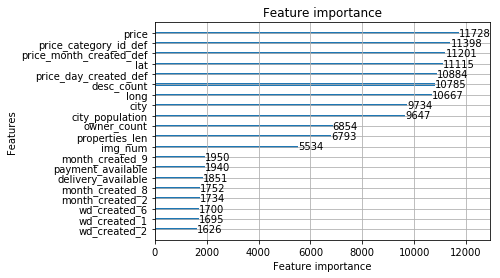

In [0]:
plt.figure(figsize=(10,10))
print('Plotting feature importances...')
ax = lgb.plot_importance(clf, max_num_features=20);
plt.show()

In [0]:
df_submission = pd.DataFrame({'score': lgb_test_pred}, 
                                 index=test_df.index)

submission_filename = 'lgb_submit.csv'
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to lgb_submit.csv


Leader Board Score: **0.63403**


#### Things that we tried:
* All the features that were commented in chosen_cols.
* We tried to use TfidfVectorizer with StemmingLemmatizingTokenizer for name_text and desc_text, but it gave only decline
* Tried different processing approaches for categorical features(LabelEncoder, OneHotEncoder, GetDummies, TfidfVecrorizer, CountVectorizer)
* Tried remove different coefficients for removing outliers. And tried with outliers.

## Cross-validation

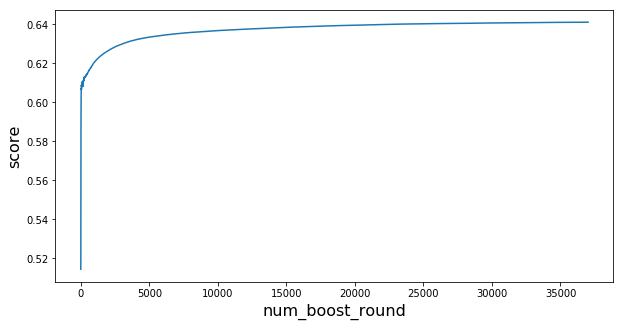

In [0]:
plt.figure(figsize=(10,5))
plt.plot(cv_results['auc-mean'])
plt.ylabel('score', fontsize=16)
plt.xlabel('num_boost_round', fontsize=16)
plt.show()

Parameter Tuning:

In [0]:
param_dict = {
        'bagging_freq': [8],
        'bagging_fraction': [0.6],
        'boost_from_average':['false'],
        'boost': ['gbdt'],
        'feature_fraction': [0.09],
        'learning_rate': [0.0075],
        'max_depth': [-1],
        'metric': ['auc'],
        'min_data_in_leaf': [50],
        'min_sum_hessian_in_leaf': [10],
        'num_leaves': [4, 8, 12],
        'num_threads': [6],
        'tree_learner': ['serial'],
        'objective': ['binary'], 
        'verbosity': [1],
        'num_boost_round': [40000]
    }


np.random.seed(1)

lgb_x_train = lgb.Dataset(X_train, label=y_train)

lg = lgb.LGBMClassifier(silent=False)

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dict, cv = 3, scoring="roc_auc", verbose=10)
grid_search.fit(X_train, target)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 121.6min remaining: 34.7min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 147.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 147.5min finished


LGBMClassifier(bagging_fraction=0.6, bagging_freq=8, boost='gbdt',
               boost_from_average='false', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.09,
               importance_type='split', learning_rate=0.0075, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=50, min_split_gain=0.0,
               min_sum_hessian_in_leaf=10, n_estimators=100, n_jobs=-1,
               num_boost_round=40000, num_leaves=8, num_threads=6,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, ...)


min_data_in_leaf | 25 | 50 | 75
--- | --- | --- | ---
**score** |  0.6395724 | 0.63938882 | 0.63912026

min_sum_hessian_in_leaf | 5 | 10 | 20
--- | --- | --- | ---
**score** | 0.63934318 | 0.63938882 | 0.63893148

But whatever initial parameters are better both on cv and lb.

# Alternative prediction methods

* Also we tried Random Forest, but to train it properly we don't have enough RAM. So score was: **0.59533**
* Decision Tree was even worser. **0.58085**

## LightGBM without OHE Encoding

We can do it because LightGBM support categorical features

In [0]:
X_train_test_alt = pd.read_pickle('X_train_test.pkl')
X_train_test_alt = X_train_test_alt[chosen_cols]

In [0]:
# Features that we will transform with OHE

alt_categorical_cols = [
    'category_id',
    'product_type',
    'subcategory_id',
    'month_created',
    'wd_created',
    'day_created',
    'city'
]

In [0]:
from sklearn.preprocessing import LabelEncoder

for col in alt_categorical_cols:
    le = LabelEncoder()
    X_train_test_alt[col] = le.fit_transform(X_train_test_alt[col])
      
X_train_alt = X_train_test_alt[:train_df.shape[0]]
X_test_alt = X_train_test_alt[train_df.shape[0]:]

In [36]:
X_train.shape, X_test.shape, target.shape

((351268, 377), (89251, 377), (351268,))

In [0]:
import lightgbm as lgb

param = {
        'bagging_freq': 8,
        'bagging_fraction': 0.6,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.09,
        'learning_rate': 0.0075,
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 8,
        'num_threads': 6,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }


np.random.seed(1)


lgb_x_train_alt = lgb.Dataset(X_train_alt, label=target)

In [38]:
%%time

# Cross-validate
cv_results_alt = lgb.cv(param, lgb_x_train_alt, num_boost_round=40000, nfold=5, 
                    verbose_eval=100, early_stopping_rounds=500, categorical_feature = alt_categorical_cols)

print('Current parameters:\n', param)
print('\nBest num_boost_round:', len(cv_results_alt['auc-mean']))
print('Best CV score:', cv_results_alt['auc-mean'][-1])

[100]	cv_agg's auc: 0.606394 + 0.00350504
[200]	cv_agg's auc: 0.608612 + 0.00367444
[300]	cv_agg's auc: 0.61139 + 0.00356274
[400]	cv_agg's auc: 0.612145 + 0.00357936
[500]	cv_agg's auc: 0.61313 + 0.00349717
[600]	cv_agg's auc: 0.61372 + 0.00340405
[700]	cv_agg's auc: 0.614079 + 0.00337406
[800]	cv_agg's auc: 0.614952 + 0.00329591
[900]	cv_agg's auc: 0.616076 + 0.00324502
[1000]	cv_agg's auc: 0.616654 + 0.00317182
[1100]	cv_agg's auc: 0.616968 + 0.00317154
[1200]	cv_agg's auc: 0.617517 + 0.00312488
[1300]	cv_agg's auc: 0.61794 + 0.00306352
[1400]	cv_agg's auc: 0.618324 + 0.00302048
[1500]	cv_agg's auc: 0.61865 + 0.00297636
[1600]	cv_agg's auc: 0.619182 + 0.00295266
[1700]	cv_agg's auc: 0.619784 + 0.00291271
[1800]	cv_agg's auc: 0.62038 + 0.00289531
[1900]	cv_agg's auc: 0.620726 + 0.00284417
[2000]	cv_agg's auc: 0.621082 + 0.00283426
[2100]	cv_agg's auc: 0.62126 + 0.00281446
[2200]	cv_agg's auc: 0.621544 + 0.0027774
[2300]	cv_agg's auc: 0.62182 + 0.00274924
[2400]	cv_agg's auc: 0.622104

In [39]:
%%time

clf_alt = lgb.train(param, lgb_x_train_alt, 40000, verbose_eval=10, categorical_feature = alt_categorical_cols)
lgb_test_pred_alt = clf_alt.predict(X_test_alt.values, num_iteration=clf_alt.best_iteration)

CPU times: user 40min 7s, sys: 54.6 s, total: 41min 2s
Wall time: 21min 54s


Plotting feature importances...


<Figure size 720x1440 with 0 Axes>

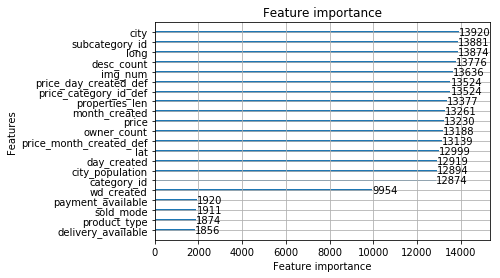

In [40]:
plt.figure(figsize=(10,20))
print('Plotting feature importances...')
ax = lgb.plot_importance(clf_alt, max_num_features=21)
plt.show()

In [41]:
df_submission = pd.DataFrame({'score': lgb_test_pred_alt}, 
                                 index=test_df.index)

submission_filename = 'lgb_alt_submit.csv'
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to lgb_alt_submit.csv


Leader Board Score: **0.61662**

## XGBoost

#### Main troubles that I faced with XGBoost:
* I don't have enough RAM to cross-validate
* It takes really big amount of time to fit(lgb x10)(6+ hours)
* Even if I could train, It gave me significant decline
* I trained without OHE features because of time

In [0]:
import xgboost as xgb

xgb_param = {
        'learning_rate': 0.0075,
        'max_depth': 75,  
        'metric':'auc',
        'num_leaves': 8,
        'nthread': 6,
        'verbosity': 1
    }

xgb_df = xgb.DMatrix(X_train, target)

In [0]:
#cvresult = xgb.cv(xgb_param, xgb_df, num_boost_round=40000, nfold=5, verbose_eval=100, early_stopping_rounds=500)

In [0]:
from xgboost import XGBClassifier

#clf = XGBClassifier(n_estimators=35000, learning_rate=0.0075, max_depth=8, n_jobs=-1, colsample_bytree=0.7, scale_pos_weight=1.)
#clf.fit(train_df, y_train)

Leader Board score: **0.54049**

## Logistic Regression

In [0]:
X_train_test_log = pd.read_pickle('X_train_test.pkl')
X_train_test_log = X_train_test_log[chosen_cols]

In [0]:
# For Logistic Regression we should scale numerical features

from sklearn.preprocessing import StandardScaler

numeric_features = [
    'img_num',
    'lat',
    'long',
    'price',
    'owner_count',
    'desc_count',
    'city_population',
    'properties_len',
    'price_category_id_def',
    'price_month_created_def',
    'price_day_created_def',
]

for feature in numeric_features:
    X_train_test_log[feature] = StandardScaler().fit_transform(X_train_test_log[feature].values.reshape(-1, 1))

In [0]:
# Features that we will transform with OHE

logistic_dummy_cols = [
    'category_id',
    'product_type',
    'subcategory_id',
    'month_created',
    'wd_created',
    'day_created',
    'city'
]

In [0]:
X_train_test_log = pd.get_dummies(X_train_test_log, columns=logistic_dummy_cols)

X_train_log = X_train_test_log[:train_df.shape[0]]
X_test_log = X_train_test_log[train_df.shape[0]:]

In [11]:
X_train_log.shape, X_test_log.shape, target.shape

((351268, 2772), (89251, 2772), (351268,))

Let's find best C parameter.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.75):
  
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed,max_iter=8000,n_jobs=1,solver='lbfgs').fit(X[:idx, :], y[:idx])
    
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [15]:
%%time

from tqdm import tqdm
from scipy.sparse import csr_matrix

# List of possible C-values
Cs = np.logspace(-1, 1, 20)

scores = []

X_train_csr = csr_matrix(X_train_log.values)
X_test_csr = csr_matrix(X_test_log.values)

for C in tqdm(Cs):
     scores.append(get_auc_lr_valid(X_train_csr, target, C=C))

100%|██████████| 20/20 [16:46<00:00, 82.40s/it]

CPU times: user 17min 12s, sys: 4.3 s, total: 17min 16s
Wall time: 17min 16s


In [16]:
scores, max(scores), Cs[np.argmax(scores)]

([0.6155667577126263,
  0.6153730007928222,
  0.6151656285888129,
  0.6149304396098478,
  0.6146699330619703,
  0.6143840594271116,
  0.61407248445831,
  0.6137487826601845,
  0.6134216386280945,
  0.6130724838145751,
  0.612750532625811,
  0.6124330919505179,
  0.6121477790349639,
  0.611870552856913,
  0.61166042875907,
  0.611494256316224,
  0.6113533781396702,
  0.6112374796440323,
  0.611156864228584,
  0.6110588046171079],
 0.6155667577126263,
 0.1)

Already on that stage we see, that this model is worser. But let's make a prediction.

In [17]:
logit = LogisticRegression(random_state=17, C=Cs[np.argmax(scores)], n_jobs=-1) 
logit.fit(X_train_csr, target) 

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=17,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [18]:
#cross-val score
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

score = cross_val_score(estimator=logit, X=X_train_csr, y=target, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', score)

ROC AUC score:  0.6141288508698372


Worser than lightgbm.

In [0]:
logit_predict = logit.predict_proba(X_test_csr)

In [20]:
df_submission = pd.DataFrame({'score': logit_predict[:, 1]}, index=test_df.index)

submission_filename = 'logit_submit.csv'
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to logit_submit.csv


Leader Board score: **0.60284**

So, LightGBM gives us the best result

# Model interpretation

Let's look again of feature importance:

Plotting feature importances...


<Figure size 720x720 with 0 Axes>

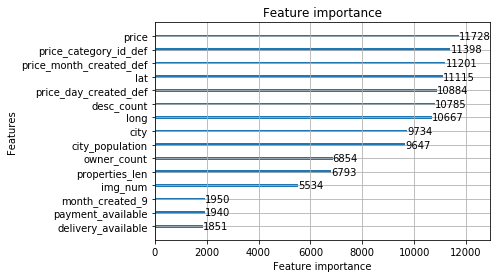

In [31]:
plt.figure(figsize=(10,10))
print('Plotting feature importances...')
ax = lgb.plot_importance(clf, max_num_features=15)
plt.show()

* We can see, that price is most important feature. So we can say, that people choose goods based on price. If price small than average for some kind of product, then it's better to buy it. Importance of price_category_id_def prove it too.
* Months is important too, because there are seasons where people buy goods, and there are where not.
* Importance of lat, long, city, city_population proves that there are some sales centers where people buy goods. For example, chanse to sell is bigger in capital than in small town.
* Days are important too. For example, people tend to buy goods after the salary, which is always in the end of month.
* Importance of desc_count, img_num, properties_len testifies that people tend to buy item, If there are a lot of information about it. It can prove to customer that this product suits them most.
* Payment_available proves that people likes to pay distantly.
* Delivery_availably proves that customers often buy goods with delivery.